In [1]:
import torch as t
from NTS_prev_umf import NTS
import matplotlib.pyplot as plt
from torch.optim import Adam

# Равномерное разбиение отрезка

In [2]:
n = 15

In [3]:
# r - разбиение, x - x_o из изначальной задачи
def function_uniform(x, r = t.linspace(0,1,n)):
    len_x = x.size()[0]
    g = t.ones(len_x)
    for i in range(len_x):
        # first = ( r[i+1].sub(x[i]) ).div( x[i].sub(r[i]) ).abs().log()
        first = t.log((r[i+1] - x[i]) / (x[i] - r[i])) 
        second = t.zeros(1)
        for k in range(len_x-1):
            if k!=i:
                second = second + t.log((r[k+1] - x[i]) / (r[k] - x[i])) + (x[k] - x[i]) * (1 / (r[k+1] - x[i]) - 1 / (r[k] - x[i]))
        g[i] = first + second
    return g    

In [4]:
def grad_function_uniform(x, r = t.linspace(0,1,n)):
    len = x.size()[0]
    dg = t.zeros([len, len])

    for i in range(len):
        for j in range(len):
            if i == j:
                dg[i][j] = - t.abs(1. / (r[i+1] - x[i])) - t.abs(1. / (x[i] - r[i]))
                for k in range(len-1):
                    if k!=i:
                        dg[i][j] += -1. / (r[k+1] - x[i]) + 1. / (r[k] - x[i]) + (1. / (r[k] - x[i]) - 1./(r[k+1] - x[i])) + (x[k] - x[i]) * (1. / (r[k+1] - x[i]).square() - 1. / (r[k] - x[i]).square())
            else:
                dg[i][j] = 1. / (r[j+1] - x[i]) - 1. / (r[j] - x[i])
    return dg

In [5]:
def train_N(function, optimizer, x, epoch):
    
    loss_line = []
    
    x_last = t.zeros_like(x)
    
    eps = 100
    step = 0
    while step < epoch:
        
        with t.no_grad():
            f = (function(x) ** 2).sum()
            loss_line.append(f)
        
        with t.no_grad():
            x_last.copy_(x)
        
        optimizer.zero_grad()
        optimizer.step()
        
        eps = ((x - x_last) ** 2).sum().sqrt()
        step += 1
    
        #print(' ' * 60, end='\r')
        print('eps = {}  step = {}     '.format(eps, step), end='\r')
    
    print(' ' * 60, end='\r')
    print('eps = {} step = {} f = {}'.format(eps.tolist(), step, f))
    print(x.tolist())
        
    return loss_line

In [12]:
r = t.linspace(0,1,n)
x = r[:-1]+(r[1]-r[0])/4.0
x = t.tensor(x,  dtype= t.float32, requires_grad = True)

/home/yakub/Desktop/summer_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
import time
start = time.time()
optimizer = NTS([x], function_uniform, grad_function_uniform, epoch=10, adaptive_lr=True,adaptive_L=True, limit_L=1e-2, limit_recurse=4, lr=1e-2)
loss = train_N(function_uniform,optimizer,x,100) 
print('time = {}'.format(time.time() - start))

eps = 0.0 step = 100 f = 4.784292697906494                  
[0.055509019643068314, 0.1030096709728241, 0.1771797388792038, 0.24834008514881134, 0.31970059871673584, 0.3911381959915161, 0.4625542461872101, 0.5339847803115845, 0.6054207682609558, 0.6768724918365479, 0.7483736872673035, 0.8198472857475281, 0.8916033506393433, 0.9649708867073059]
time = 18.942607879638672


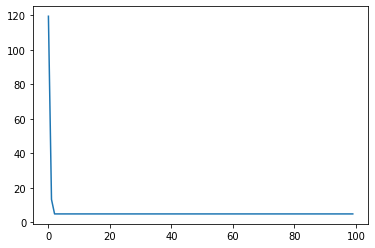

In [10]:
plt.plot(loss)

In [ ]:
plt.plot(loss[-10:])

In [ ]:
def train_s(function, optimizer, x, epoch):
    
    loss_line = []
    
    x_last = t.zeros_like(x)
    
    eps = 100
    step = 0
    while step < epoch:
        f = (function(x) ** 2).sum()
        
        with t.no_grad():
            loss_line.append(f)
        
        with t.no_grad():
            x_last.copy_(x)
        
        optimizer.zero_grad()
        f.backward()
        optimizer.step()
        
        eps = ((x - x_last) ** 2).sum().sqrt()
        step += 1
    
        #print(' ' * 60, end='\r')
        print('eps = {}  step = {}    '.format(eps, step), end='\r')
    
    print(' ' * 60, end='\r')
    print('eps = {} step = {} f = {}'.format(eps.tolist(), step, f))
    print(x.tolist())
        
    return loss_line

In [ ]:
r = t.linspace(0,1,n)
x = r[:-1]+(r[1]-r[0])/4.0
x = t.tensor(x,  dtype= t.float32, requires_grad = True)

In [ ]:
optimizer = Adam([x], lr=1e-3)
loss = train_s(function_uniform, optimizer, x, 100)

In [ ]:
plt.plot(loss)

# Неравномерное разбиение отрезка

In [ ]:
import random

def generate_norm_split(n):
    
    n1 = n // 2
    n2 = n - n1
    
    r1 = t.randn(n1).abs() / 3
    r2 = 1 - t.randn(n2).abs() / 3
    
    return t.cat([r1, r2]).sort()[0]

def generate_norm_x(r):
    
    x = t.zeros_like(r[:-1])
    
    for i, _ in enumerate(x):
        x[i] = r[i] + (r[i + 1] - r[i]) / 4.
        
    return x

In [ ]:
n = 15

In [ ]:
# r - разбиение, x - x_o из изначальной задачи
def function_normal(x):
    
    global r
    
    len_x = x.size()[0]
    g = t.ones(len_x)
    for i in range(len_x):
        # first = ( r[i+1].sub(x[i]) ).div( x[i].sub(r[i]) ).abs().log()
        first = t.log((r[i+1] - x[i]) / (x[i] - r[i])) 
        second = t.zeros(1)
        for k in range(len_x-1):
            if k!=i:
                second = second + t.log((r[k+1] - x[i]) / (r[k] - x[i])) + (x[k] - x[i]) * (1 / (r[k+1] - x[i]) - 1 / (r[k] - x[i]))
        g[i] = first + second
    return g    

# Adam

In [ ]:
r = generate_norm_split(n)
x0 = generate_norm_x(r)
print(r)
print(x0)

In [ ]:
x = t.zeros_like(x0, requires_grad=True)
with t.no_grad():
    x.copy_(x0)

In [ ]:
optimizer = Adam([x], lr=1e-4)
loss_Adam = train_s(function_normal, optimizer, x, 1000)

In [ ]:
plt.plot(loss_Adam[:100])

In [ ]:
plt.plot(loss_Adam[-100:])

# NTS

In [ ]:
x = t.zeros_like(x0, requires_grad=True)
with t.no_grad():
    x.copy_(x0)

In [ ]:
optimizer = NTS([x], function_normal, epoch=10, adaptive_lr=True,
                adaptive_L=True, limit_L=1e-2, limit_recurse=4, lr=1e-2)
loss_NTS = train_N(function_normal, optimizer ,x , 1000) 

In [ ]:
print(x0)
print(r)

In [ ]:
plt.plot(loss_NTS)

In [ ]:
plt.plot(loss_NTS[-10:])

In [ ]:
(x > r[:-1]) & (x < r[1:])

In [ ]:
junc_line = []

In [ ]:
junc_line